In [117]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statistics import mean
from pmdarima import auto_arima
import pandas as pd
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [118]:
data = pd.read_csv('finalized_county.csv')

In [119]:
tarrant = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
tarrant['incremental_cases'] = tarrant['incremental_cases'].astype('int')
tarrant['date'] = pd.to_datetime(tarrant['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = tarrant.iloc[:230, :]
test = tarrant.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

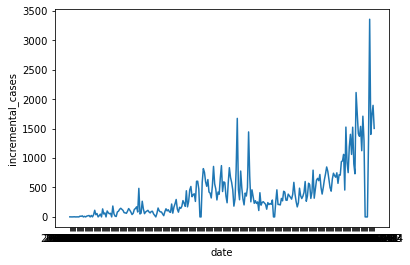

In [120]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Tarrant'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [121]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

best_score, best_model = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.iloc[train_index, :], train.iloc[val_index, :]

    model = auto_arima(train_data.incremental_cases, seasonal=True, stepwise=True,
                       suppress_warnings=True, error_action="ignore",
                       start_p=1, start_q=1, max_p=8, max_q=8, d=None, trace=True)

    # Forecast
    forecast = model.predict(n_periods=val_data.shape[0])
    
    # Evaluate
    mse = mean_squared_error(val_data.incremental_cases, forecast)
    if mse < best_score:
        best_score = mse
        best_model = model

print(f'Best ARIMA model summary:')
print(best_model.summary())
print(f'with MSE: {best_score}')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=621.873, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=610.425, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=620.014, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=611.696, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=608.777, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=610.104, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=598.795, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=597.033, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=598.804, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.310 seconds
Performing stepwise search to minimize aic
 ARIMA(1

In [122]:
# Fit the model with specified ARIMA(0,1,1) parameters
model = auto_arima(train.incremental_cases, start_p=0, start_q=0, max_p=3, max_q=2, d=1,
                   seasonal=True, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Forecast the next 40 steps beyond the train dataset
pred, conf_int = model.predict(n_periods=40, return_conf_int=True)

lower_bounds = conf_int[:, 0]
upper_bounds = conf_int[:, 1]

r2 = r2_score(test.incremental_cases, pred)  # Ensure test data is the correct length
print("R-squared", r2)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3077.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3071.129, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3018.384, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3075.347, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3005.841, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2987.264, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3027.001, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2989.219, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2990.177, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3020.853, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2989.377, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2987.337, Time=0.42 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.649 seconds
R-squared -0.29327743985654

In [123]:
print('mape: ', mean_absolute_error(test.incremental_cases, pred)/mean(test.incremental_cases))

mape:  0.4765848475278259


<AxesSubplot:xlabel='date'>

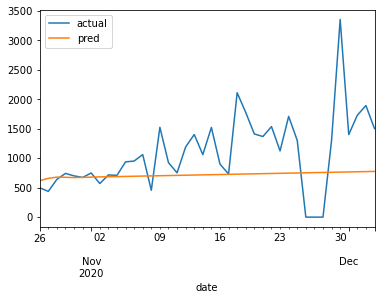

In [94]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

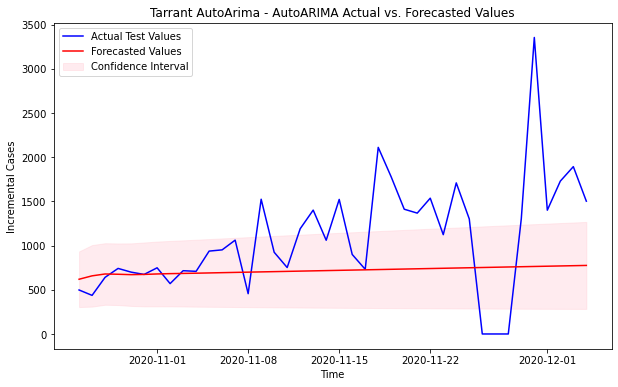

In [95]:
import matplotlib.pyplot as plt

# Plot actual test values
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test.incremental_cases, label='Actual Test Values', color='blue')

# Plot forecasted values
plt.plot(test['date'], pred, label='Forecasted Values', color='red')

plt.fill_between(test['date'], lower_bounds, upper_bounds, color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Tarrant AutoArima - AutoARIMA Actual vs. Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Incremental Cases')
plt.legend()
plt.show()

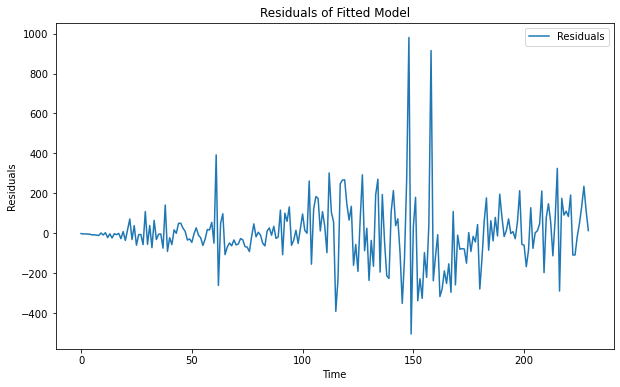

In [96]:
# Plotting Residuals
fitted_values = model.predict_in_sample()
residuals = train.incremental_cases - fitted_values

plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Fitted Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [97]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  230
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1488.632
Date:                Wed, 13 Mar 2024   AIC                           2987.264
Time:                        00:56:22   BIC                           3004.433
Sample:                             0   HQIC                          2994.191
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0088      2.436      1.235      0.217      -1.765       7.782
ar.L1          0.2856      0.049      5.774      0.000       0.189       0.383
ar.L2         -0.3149      0.068     -4.641      0.000      -0.448      -0.182
ma.L1         -0.8124      0.049    -16.625      0.000      -0.908      -0.717
sigma2      2.579e+04   1426.380     18.082      0.000     2.3e+04    2.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               997.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.26   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [124]:
harris = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
harris['incremental_cases'] = harris['incremental_cases'].astype('int')
harris['date'] = pd.to_datetime(harris['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = harris.iloc[:230, :]
test = harris.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

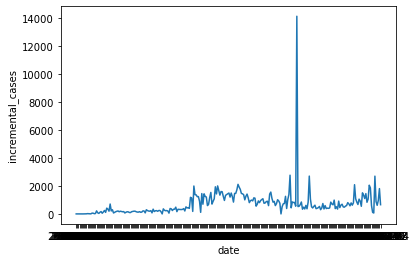

In [125]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Harris'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [126]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

best_score, best_model = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.iloc[train_index, :], train.iloc[val_index, :]

    model = auto_arima(train_data.incremental_cases, seasonal=False, stepwise=True,
                       suppress_warnings=True, error_action="ignore",
                       start_p=1, start_q=1, max_p=8, max_q=8, d=None, trace=True)

    # Forecast
    forecast = model.predict(n_periods=val_data.shape[0])
    
    # Evaluate
    mse = mean_squared_error(val_data.incremental_cases, forecast)
    if mse < best_score:
        best_score = mse
        best_model = model

print(f'Best ARIMA model summary:')
print(best_model.summary())
print(f'with MSE: {best_score}')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=699.341, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=724.329, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=701.876, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=699.707, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=722.349, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=698.963, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=697.838, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=699.237, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=700.936, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=695.989, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=699.950, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=697.358, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=697.087, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=697.520, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=699.0

In [127]:
# Fit the model with specified ARIMA(1,0,2) parameters
model = auto_arima(train.incremental_cases, start_p=0, start_q=0, max_p=3, max_q=2, d=1,
                   seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Forecast the next 40 steps beyond the train dataset
pred, conf_int = model.predict(n_periods=40, return_conf_int=True) 

lower_bounds = conf_int[:, 0]
upper_bounds = conf_int[:, 1]

r2 = r2_score(test.incremental_cases, pred)  # Ensure test data is the correct length
print("R-squared", r2)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3948.349, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3884.202, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3806.533, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3946.351, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3808.470, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3808.469, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3810.132, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3804.874, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3806.791, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3806.788, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3882.204, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3808.378, Time=0.17 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.840 seconds
R-squared -0.20410793002061722


In [128]:
print('mape: ', mean_absolute_error(test.incremental_cases, pred)/mean(test.incremental_cases))

mape:  0.4261567914816227


<AxesSubplot:xlabel='date'>

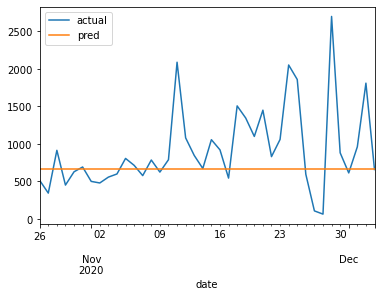

In [129]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

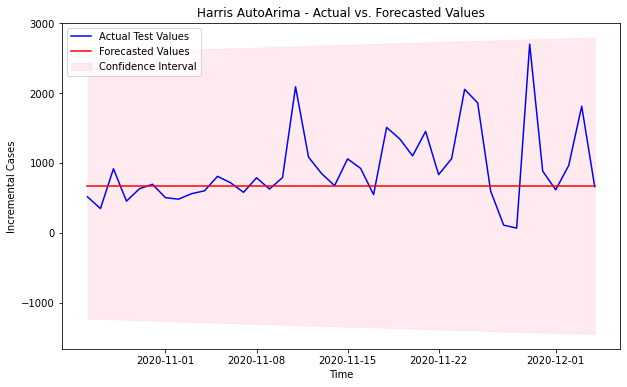

In [130]:
import matplotlib.pyplot as plt

# Plot actual test values
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test.incremental_cases, label='Actual Test Values', color='blue')

# Plot forecasted values
plt.plot(test['date'], pred, label='Forecasted Values', color='red')

plt.fill_between(test['date'], lower_bounds, upper_bounds, color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Harris AutoArima - Actual vs. Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Incremental Cases')
plt.legend()
plt.show()

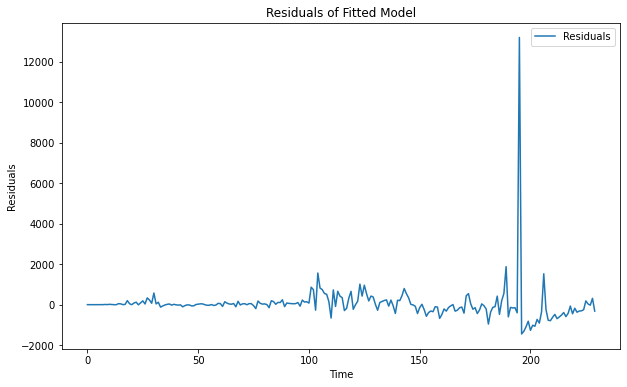

In [131]:


# Plotting residuals
fitted_values = model.predict_in_sample()
residuals = train.incremental_cases - fitted_values


plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Fitted Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [132]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  230
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1900.437
Date:                Wed, 13 Mar 2024   AIC                           3804.874
Time:                        11:19:24   BIC                           3811.742
Sample:                             0   HQIC                          3807.645
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9204      0.032    -28.334      0.000      -0.984      -0.857
sigma2      9.402e+05   1.06e+04     89.035      0.000    9.19e+05    9.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):            209266.87
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):             246.54   Skew:                            10.97
Prob(H) (two-sided):                  0.00   Kurtosis:                       149.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
philly = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
philly['incremental_cases'] = philly['incremental_cases'].astype('int')
philly['date'] = pd.to_datetime(philly['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = philly.iloc[:230, :]
test = philly.iloc[230:, :]

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])


<AxesSubplot:xlabel='date', ylabel='incremental_cases'>

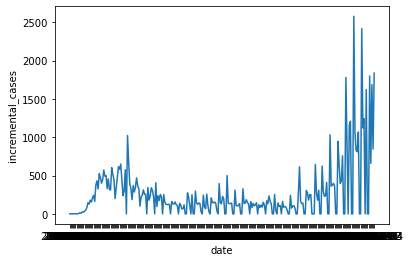

In [134]:
# use non-differenced cases for test actuals
testing = data[data['county'] == 'Philadelphia'].loc[:, ['date', 'incremental_cases']]
test = testing.iloc[230:, :]

# Plotting actual test data
sns.lineplot(x="date", y="incremental_cases",legend = 'full' , data=testing)

In [135]:
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns='index')

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

best_score, best_model = float("inf"), None

for train_index, val_index in tscv.split(train):
    train_data, val_data = train.iloc[train_index, :], train.iloc[val_index, :]

    model = auto_arima(train_data.incremental_cases, seasonal=False, stepwise=True,
                       suppress_warnings=True, error_action="ignore",
                       start_p=1, start_q=1, max_p=8, max_q=8, d=None, trace=True)

    # Forecast
    forecast = model.predict(n_periods=val_data.shape[0])
    
    # Evaluate
    mse = mean_squared_error(val_data.incremental_cases, forecast)
    if mse < best_score:
        best_score = mse
        best_model = model

print(f'Best ARIMA model summary:')
print(best_model.summary())
print(f'with MSE: {best_score}')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=760.847, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=781.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=768.038, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=758.893, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=779.607, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=760.853, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=758.164, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=760.163, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=760.163, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=766.177, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=762.164, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.309 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1465.671, Time=0.07

In [136]:
# Fit the model with specified ARIMA(1,0,2) parameters
model = auto_arima(train.incremental_cases, start_p=0, start_q=1, max_p=7, max_q=2, d=1,
                   seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)

# Forecast the next 40 steps beyond the train dataset
pred, conf_int = model.predict(n_periods=40, return_conf_int=True) 

lower_bounds = conf_int[:, 0]
upper_bounds = conf_int[:, 1]

r2 = r2_score(test.incremental_cases, pred)  # Ensure test data is the correct length
print("R-squared", r2)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2911.689, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3022.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2977.761, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3020.558, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2913.678, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2913.674, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2914.011, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2909.880, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2911.869, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2911.865, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2975.761, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2912.209, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.626 seconds
R-squared -0.6732711704114347


In [137]:
print('mape: ', mean_absolute_error(test.incremental_cases, pred)/mean(test.incremental_cases))

mape:  0.9043376312557261


<AxesSubplot:xlabel='date'>

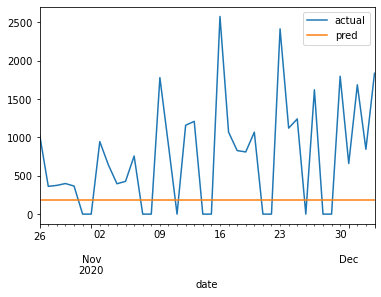

In [138]:
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d")

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True), 
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

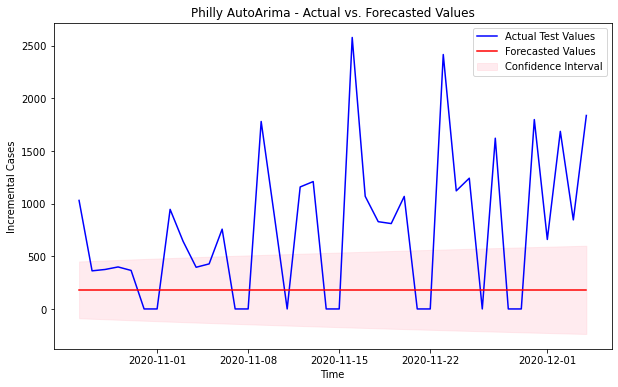

In [139]:
import matplotlib.pyplot as plt

# Plot actual test values
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test.incremental_cases, label='Actual Test Values', color='blue')

# Plot forecasted values
plt.plot(test['date'], pred, label='Forecasted Values', color='red')

plt.fill_between(test['date'], lower_bounds, upper_bounds, color='pink', alpha=0.3, label='Confidence Interval')

plt.title('Philly AutoArima - Actual vs. Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Incremental Cases')
plt.legend()
plt.show()

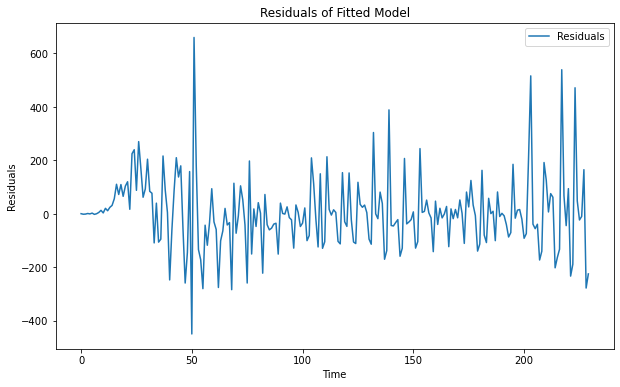

In [140]:


# Plotting residuals
fitted_values = model.predict_in_sample()
residuals = train.incremental_cases - fitted_values


plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals of Fitted Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [113]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  230
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1452.940
Date:                Wed, 13 Mar 2024   AIC                           2909.880
Time:                        00:56:47   BIC                           2916.747
Sample:                             0   HQIC                          2912.650
                                - 230                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8092      0.038    -21.369      0.000      -0.883      -0.735
sigma2       1.89e+04   1148.630     16.456      0.000    1.67e+04    2.12e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               175.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.96
Prob(H) (two-sided):                  0.40   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""